# Stroke prediction with a voting classifier

In [25]:
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/)

data/healthcare-dataset-stroke-data.csv


In [26]:
file = 'data/healthcare-dataset-stroke-data.csv'
data = pd.read_csv(file)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [27]:
data = data.drop(columns = ['id'])

<Figure size 1800x1800 with 0 Axes>

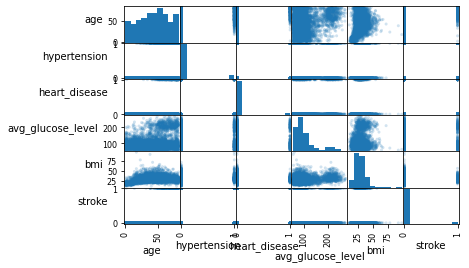

In [28]:
plt.figure(figsize=(25,25))
axes = pd.plotting.scatter_matrix(data,alpha=0.2)

for ax in axes.flatten():
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

## Dealing with missing values

Only bmi contains NA values. We will impute them with the mean (after transformation).

In [29]:
data.isna().sum(axis = 0)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## Exploratory data analysis

In [30]:
# data distribution and types
print(data.dtypes)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [31]:
numerical_cols = data.select_dtypes(include=float).columns

I will use a quatile transform on average glucose level and log transformation on bmi, since they are bimodal and right-skewed respectively

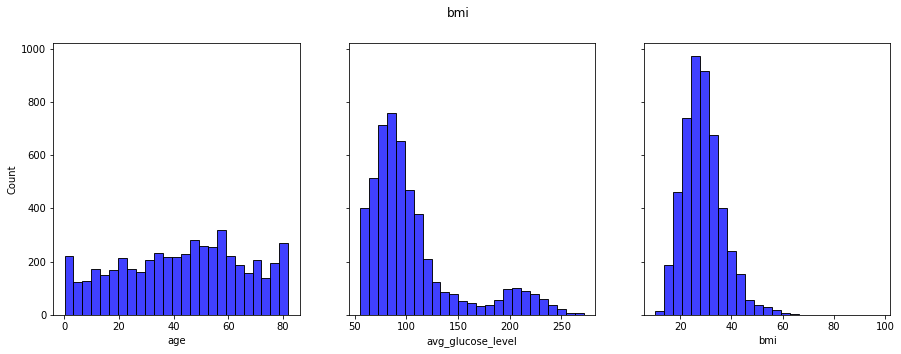

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, nc in enumerate(numerical_cols):
    fig.suptitle(nc)
    sns.histplot(data = data[nc], color='b', bins=25, ax = axes[i])

In [33]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
quantile_transformer = QuantileTransformer()
log_transformer = FunctionTransformer(np.log)

They are ready for modeling after transformation

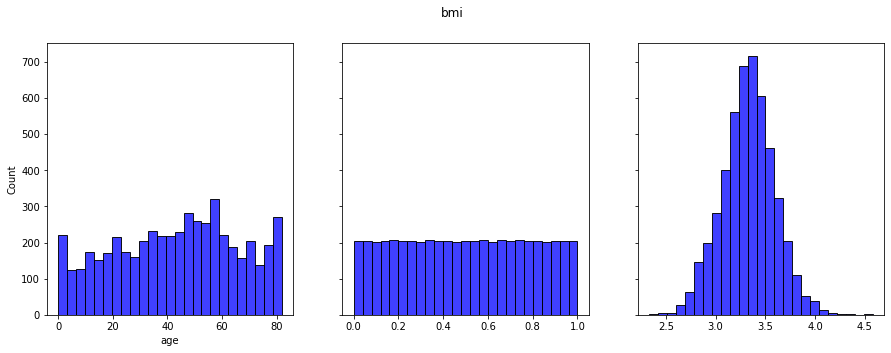

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, nc in enumerate(numerical_cols):
    fig.suptitle(nc)
    if nc == 'bmi':
        data_reshaped = data[nc].values.reshape(-1,1)
        sns.histplot(data = log_transformer.fit_transform(data_reshaped).squeeze(),
                     color='b', 
                     bins=25, 
                     ax = axes[i])
    elif nc == 'avg_glucose_level':
        data_reshaped = data[nc].values.reshape(-1,1)
        sns.histplot(data = quantile_transformer.fit_transform(data_reshaped).squeeze(), 
                     color='b', 
                     bins=25, 
                     ax = axes[i])
    else:
        sns.histplot(data = data[nc], color='b', bins=25, ax = axes[i])

Here we are inspecting number of classes of the categorical features

In [35]:
# list categorical data and their respective number of classes
categorical_cols = data.select_dtypes(include=object).columns
for c in categorical_cols:
    print((c, len(data[c].unique())))

('gender', 3)
('ever_married', 2)
('work_type', 5)
('Residence_type', 2)
('smoking_status', 4)


We simply use one-hot encoding for all these features. To summarize, we first log transform bmi and quantile normalize glucose level. We then impute bmi with the mean value. We apply one-hot encoding on all categorical columns. We finally re-standardize all columns. This results in the pipeline below.

In [36]:
X, y = data.drop(columns = 'stroke'), data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

There' one extra step before we build our models. The number of cases and controls are disproportionate, i.e we have a very imbalanced dataset. We need to further oversample the cases. 

sample size =  5110
# of stroke cases = 249


<AxesSubplot:xlabel='stroke', ylabel='count'>

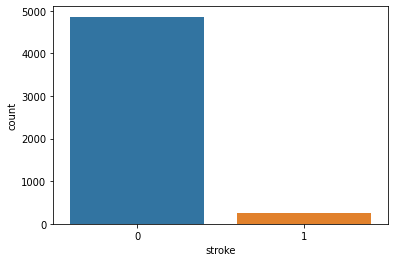

In [37]:
print(f'sample size =  {len(data)}')
n_cases = data['stroke'].sum()
print(f'# of stroke cases = {n_cases}')
sns.countplot(x = 'stroke', data = data)

In [38]:
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

bmi_transformer = Pipeline(steps=[
    ('log_tran', log_transformer),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

glucose_transformer = Pipeline(steps=[
    ('quantile_tran', quantile_transformer),
    ('scaler', StandardScaler())])

age_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', bmi_transformer, ['bmi']),
        ('glucose', glucose_transformer, ['avg_glucose_level']),
        ('age', age_transformer, ['age']),
        ('cat', categorical_transformer, categorical_cols)])

smote = SMOTE(random_state=42)

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import VotingClassifier

In [40]:
rfc = RandomForestClassifier(n_estimators=100)
adac = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
dctc = DecisionTreeClassifier()
lrc = RidgeClassifier()

classifiers = [('Random Forest', rfc ),
               ('Logistic regression', lrc),
               ('Adaboost', adac),
               ('GradientBoostingClassifier', gbc),
               ('Classification Tree', dctc)]

vc = VotingClassifier(estimators=classifiers)

In [41]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('smote', smote),
                      ('vc', vc)])

In [42]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bmi',
                                                  Pipeline(steps=[('log_tran',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('glucose',
                                                  Pipeline(steps=[('quantile_tran',
                                                                   QuantileTransformer()),
                                                                  ('scaler',
                     

The result does not seem that great but it's better than most notebook shared here

In [43]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1458
           1       0.14      0.45      0.21        75

    accuracy                           0.83      1533
   macro avg       0.55      0.65      0.56      1533
weighted avg       0.93      0.83      0.87      1533



While this is a classification problem, we would like to dig deeply into what variables are associated with the stroke status, since that informs clinical practioners for further examinations or experiments. 

In [44]:
# pickle our model for deployment
import pickle
with open("classifier.pkl", "wb") as classifier_pkl:
    pickle.dump(clf, classifier_pkl)